## Setup the Env


In [1]:
import os
import sys

import sagemaker
from sagemaker import get_execution_role

# Add the parent directory to the sys.path
sys.path.insert(0, os.path.abspath(".."))

# Define IAM role
role = get_execution_role()
role

# Establish S3 bucket connection
import boto3

s3 = boto3.client("s3")
bucket = "capstone-bucket-4-friends"

# Take a look at current dir
print(os.getcwd())

from file_utilities import s3_download

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
/home/sagemaker-user/capstone-2024-summer/src/shuo


## Import Package

In [2]:
!pip install seaborn
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import joblib
import time
import logging
import torch.distributions as dist
from sklearn.preprocessing import StandardScaler


warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

In [3]:
# pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113


In [4]:
torch.cuda.is_available()


True

In [5]:
import torch
import torch.nn as nn

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

# Example model
model = nn.Linear(10, 2)

# Move model to the device (GPU if available)
model.to(device)

# Example data
x = torch.randn(1, 10).to(device)
output = model(x)
print(output)


CUDA is available. Using GPU.
tensor([[ 0.2532, -0.2882]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Load Data

In [7]:
# reload_path = s3_download("CRSP/crsp_2018-2023_clean_3.parquet")
# reload_path

In [8]:
os.getcwd()

'/home/sagemaker-user/capstone-2024-summer/src/shuo'

In [9]:
!pwd

/home/sagemaker-user/capstone-2024-summer/src/shuo


In [10]:
df = pd.read_parquet("../../data/crsp_2018-2023_clean_3.parquet")

In [11]:
df

date permno_id ncusip_id  cusip_id ticker share_code  \
9263    2018-01-02     10104  68389X10  68389X10   ORCL       11.0   
9264    2018-01-03     10104  68389X10  68389X10   ORCL       11.0   
9265    2018-01-04     10104  68389X10  68389X10   ORCL       11.0   
9266    2018-01-05     10104  68389X10  68389X10   ORCL       11.0   
9267    2018-01-08     10104  68389X10  68389X10   ORCL       11.0   
...            ...       ...       ...       ...    ...        ...   
7656951 2023-12-22     93436  88160R10  88160R10   TSLA       11.0   
7656952 2023-12-26     93436  88160R10  88160R10   TSLA       11.0   
7656953 2023-12-27     93436  88160R10  88160R10   TSLA       11.0   
7656954 2023-12-28     93436  88160R10  88160R10   TSLA       11.0   
7656955 2023-12-29     93436  88160R10  88160R10   TSLA       11.0   

        share_code_type share_code_detail exchange_code company_name  \
9263                  1                 1             1  ORACLE CORP   
9264                  1                 1             1  ORACLE CORP   
9265                  1                 1             1  ORACLE CORP   
9266                  1                 1             1  ORACLE CORP   
9267                  1                 1             1  ORACLE CORP   
...                 ...               ...           ...          ...   
7656951               1                 1             3    TESLA INC   
7656952               1                 1             3    TESLA INC   
7656953               1                 1             3    TESLA INC   
7656954               1                 1             3    TESLA INC   
7656955               1                 1             3    TESLA INC   

        primary_exchange trading_status security_status     naics  \
9263                   N              A               R  511210.0   
9264                   N              A               R  511210.0   
9265                   N              A               R  511210.0   
9266                   N              A               R  511210.0   
9267                   N              A               R  511210.0   
...                  ...            ...             ...       ...   
7656951                Q              A               R  336110.0   
7656952                Q              A               R  336110.0   
7656953                Q              A               R  336110.0   
7656954                Q              A               R  336110.0   
7656955                Q              A               R  336110.0   

        naics_sector naics_sector_name naics_secondary  ask_or_high_price  \
9263              51       Information          1210.0            47.8011   
9264              51       Information          1210.0            48.0700   
9265              51       Information          1210.0            48.1900   
9266              51       Information          1210.0            48.6300   
9267              51       Information          1210.0            49.0700   
...              ...               ...             ...                ...   
7656951           33     Manufacturing          6110.0           258.2200   
7656952           33     Manufacturing          6110.0           257.9700   
7656953           33     Manufacturing          6110.0           263.3400   
7656954           33     Manufacturing          6110.0           265.1300   
7656955           33     Manufacturing          6110.0           255.1900   

         ask_price  bid_or_low_price  bid_price  open_price  close_price  \
9263      46.63000          46.17000   46.62000    47.57000     46.63000   
9264      47.71000          47.44000   47.70000    47.53000     47.71000   
9265      48.18000          47.71500   48.17000    47.99000     48.18000   
9266      48.45000          48.28000   48.44000    48.42000     48.47000   
9267      48.99000          47.94000   48.98000    48.30000     48.98000   
...            ...               ...        ...         ...          ...   
7656951  252.53999    

In [12]:
df.dtypes

date                              datetime64[ns]
permno_id                                 object
ncusip_id                                 object
cusip_id                                  object
ticker                                    object
share_code                                object
share_code_type                           object
share_code_detail                         object
exchange_code                             object
company_name                              object
primary_exchange                          object
trading_status                            object
security_status                           object
naics                                     object
naics_sector                              object
naics_sector_name                         object
naics_secondary                           object
ask_or_high_price                        float64
ask_price                                float64
bid_or_low_price                         float64
bid_price           

## Feature Engineering

### Feature Selection

In [13]:
data = df[
    [
        "date",
        "permno_id",
        # "naics",
        "log_return",
        "abs_log_return",
        "sector_weighted_avg_log_return",
        "sector_simple_avg_log_return",
        "weighted_avg_log_return",
        "simple_avg_log_return",
        "log_return_7",
        "abs_log_return_7",
        "log_return_14",
        "abs_log_return_14",
        "log_return_28",
        "abs_log_return_28",
        "volatility_7",
        "volatility_14",
        "volatility_28",
    ]
].copy()
data

date permno_id  log_return  abs_log_return  \
9263    2018-01-02     10104   -0.013843        0.013843   
9264    2018-01-03     10104    0.022897        0.022897   
9265    2018-01-04     10104    0.009803        0.009803   
9266    2018-01-05     10104    0.006001        0.006001   
9267    2018-01-08     10104    0.010467        0.010467   
...            ...       ...         ...             ...   
7656951 2023-12-22     93436   -0.007731        0.007731   
7656952 2023-12-26     93436    0.015988        0.015988   
7656953 2023-12-27     93436    0.018647        0.018647   
7656954 2023-12-28     93436   -0.032104        0.032104   
7656955 2023-12-29     93436   -0.018738        0.018738   

         sector_weighted_avg_log_return  sector_simple_avg_log_return  \
9263                           0.000000                      0.000000   
9264                           0.006404                      0.004872   
9265                           0.004048                      0.000960   
9266                           0.009581                      0.006722   
9267                           0.002142                      0.005354   
...                                 ...                           ...   
7656951                        0.000259                      0.007069   
7656952                        0.007335                      0.009616   
7656953                        0.002344                      0.001393   
7656954                       -0.001451                     -0.000214   
7656955                       -0.005400                     -0.005035   

         weighted_avg_log_return  simple_avg_log_return  log_return_7  \
9263                    0.000000               0.000000      0.309424   
9264                    0.005904               0.007983      0.234088   
9265                    0.004021               0.000852      0.183199   
9266                    0.006193               0.002919      0.230474   
9267                    0.001829               0.005828      0.161223   
...                          ...                    ...           ...   
7656951                 0.002502               0.004469      0.000000   
7656952                 0.005189               0.003873      0.000000   
7656953                 0.001653               0.001163      0.000000   
7656954                -0.000266               0.002184      0.000000   
7656955                -0.004121              -0.004627      0.000000   

         abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
9263             0.309424       0.131071           0.131071       0.011619   
9264             0.234088       0.107382           0.107382       0.006475   
9265             0.183199       0.097613           0.097613       0.009651   
9266             0.230474       0.120486           0.120486       0.015437   
9267             0.161223       0.083731           0.083731       0.012476   
...                   ...            ...                ...            ...   
7656951          0.000000       0.000000           0.000000       0.000000   
7656952          0.000000       0.000000           0.000000       0.000000   
7656953          0.000000       0.000000           0.000000       0.000000   
7656954          0.000000       0.000000           0.000000       0.000000   
7656955          0.000000       0.000000           0.000000       0.000000   

         abs_log_return_28  volatility_7  volatility_14  volatility_28  
9263              0.011619      0.136136       0.109282       0.276310  
9264              0.006475      0.091648       0.081082       0.268724  
9265              0.009651      0.089939       0.079524       0.273385  
9266              0.015437      0.105015       0.107098       0.281463  
9267              0.012476      0.105560       0.139328       0.280139  
...                    ...           ...            ...            ...  
7656951           0.000000      0.000000       0.000000       0.000000  
7656952           

### Standardize features and labels

In [14]:
columns = [
    "log_return",
    "sector_weighted_avg_log_return",
    "sector_simple_avg_log_return",
    "weighted_avg_log_return",
    "simple_avg_log_return",
    "abs_log_return",
    "log_return_7",
    "abs_log_return_7",
    "log_return_14",
    "abs_log_return_14",
    "log_return_28",
    "abs_log_return_28",
    "volatility_7",
    "volatility_14",
    "volatility_28",
]
scaler = StandardScaler()

data[columns] =scaler.fit_transform(data[columns])
data

date permno_id  log_return  abs_log_return  \
9263    2018-01-02     10104   -0.599913       -0.077145   
9264    2018-01-03     10104    0.953274        0.423184   
9265    2018-01-04     10104    0.399725       -0.300443   
9266    2018-01-05     10104    0.239003       -0.510547   
9267    2018-01-08     10104    0.427805       -0.263735   
...            ...       ...         ...             ...   
7656951 2023-12-22     93436   -0.341505       -0.414949   
7656952 2023-12-26     93436    0.661183        0.041348   
7656953 2023-12-27     93436    0.773615        0.188324   
7656954 2023-12-28     93436   -1.371871        0.931997   
7656955 2023-12-29     93436   -0.806852        0.193376   

         sector_weighted_avg_log_return  sector_simple_avg_log_return  \
9263                          -0.018430                     -0.009147   
9264                           0.328289                      0.302093   
9265                           0.200733                      0.052181   
9266                           0.500294                      0.420277   
9267                           0.097540                      0.332884   
...                                 ...                           ...   
7656951                       -0.004407                      0.442444   
7656952                        0.378694                      0.605155   
7656953                        0.108477                      0.079842   
7656954                       -0.096988                     -0.022818   
7656955                       -0.310790                     -0.330800   

         weighted_avg_log_return  simple_avg_log_return  log_return_7  \
9263                   -0.025258              -0.017993      0.511707   
9264                    0.420004               0.618797      0.355892   
9265                    0.277994               0.049970      0.250640   
9266                    0.441800               0.214851      0.348418   
9267                    0.112680               0.446897      0.205187   
...                          ...                    ...           ...   
7656951                 0.163436               0.338492     -0.128265   
7656952                 0.366081               0.290950     -0.128265   
7656953                 0.099407               0.074778     -0.128265   
7656954                -0.045319               0.156221     -0.128265   
7656955                -0.336051              -0.387080     -0.128265   

         abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
9263             0.201900       1.097317           0.702858       0.215318   
9264             0.028348       0.879456           0.403960       0.079349   
9265            -0.088885       0.789610           0.280693       0.163295   
9266             0.020023       0.999965           0.569295       0.316238   
9267            -0.139512       0.661939           0.105531       0.237967   
...                   ...            ...                ...            ...   
7656951         -0.510924      -0.108108          -0.950953      -0.091799   
7656952         -0.510924      -0.108108          -0.950953      -0.091799   
7656953         -0.510924      -0.108108          -0.950953      -0.091799   
7656954         -0.510924      -0.108108          -0.950953      -0.091799   
7656955         -0.510924      -0.108108          -0.950953      -0.091799   

         abs_log_return_28  volatility_7  volatility_14  volatility_28  
9263             -0.548049     -0.716988      -0.942127      -0.192751  
9264             -0.737177     -0.911900      -1.074948      -0.230518  
9265             -0.620411     -0.919385      -1.082285      -0.207312  
9266             -0.407673     -0.853336      -0.952413      -0.167097  
9267             -0.516545     -0.850950      -0.800611      -0.173688  
...                    ...           ...            ...            ...  
7656951          -0.975239     -1.313432      -1.456839      -1.568281  
7656952          -

In [15]:
# Function to filter the first n stocks
def filter_first_n_stocks(data, n):
    first_n_permno_ids = data["permno_id"].unique()[:n]
    return data[data["permno_id"].isin(first_n_permno_ids)]

In [16]:
# Filter the first n stocks
n_stocks = 50  # Adjust n as needed
data = filter_first_n_stocks(data, n_stocks)
data

date permno_id  log_return  abs_log_return  \
9263   2018-01-02     10104   -0.599913       -0.077145   
9264   2018-01-03     10104    0.953274        0.423184   
9265   2018-01-04     10104    0.399725       -0.300443   
9266   2018-01-05     10104    0.239003       -0.510547   
9267   2018-01-08     10104    0.427805       -0.263735   
...           ...       ...         ...             ...   
565093 2023-12-22     13641    0.020472       -0.796222   
565094 2023-12-26     13641    0.685016        0.072503   
565095 2023-12-27     13641   -0.257320       -0.525000   
565096 2023-12-28     13641   -0.759238        0.131133   
565097 2023-12-29     13641   -0.082761       -0.753192   

        sector_weighted_avg_log_return  sector_simple_avg_log_return  \
9263                         -0.018430                     -0.009147   
9264                          0.328289                      0.302093   
9265                          0.200733                      0.052181   
9266                          0.500294                      0.420277   
9267                          0.097540                      0.332884   
...                                ...                           ...   
565093                        0.289091                      0.408714   
565094                        0.613990                      0.826703   
565095                       -0.131855                     -0.012597   
565096                       -0.782195                     -0.858605   
565097                       -0.264825                     -0.474793   

        weighted_avg_log_return  simple_avg_log_return  log_return_7  \
9263                  -0.025258              -0.017993      0.511707   
9264                   0.420004               0.618797      0.355892   
9265                   0.277994               0.049970      0.250640   
9266                   0.441800               0.214851      0.348418   
9267                   0.112680               0.446897      0.205187   
...                         ...                    ...           ...   
565093                 0.163436               0.338492     -0.128265   
565094                 0.366081               0.290950     -0.128265   
565095                 0.099407               0.074778     -0.128265   
565096                -0.045319               0.156221     -0.128265   
565097                -0.336051              -0.387080     -0.128265   

        abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
9263            0.201900       1.097317           0.702858       0.215318   
9264            0.028348       0.879456           0.403960       0.079349   
9265           -0.088885       0.789610           0.280693       0.163295   
9266            0.020023       0.999965           0.569295       0.316238   
9267           -0.139512       0.661939           0.105531       0.237967   
...                  ...            ...                ...            ...   
565093         -0.510924      -0.108108          -0.950953      -0.091799   
565094         -0.510924      -0.108108          -0.950953      -0.091799   
565095         -0.510924      -0.108108          -0.950953      -0.091799   
565096         -0.510924      -0.108108          -0.950953      -0.091799   
565097         -0.510924      -0.108108          -0.950953      -0.091799   

        abs_log_return_28  volatility_7  volatility_14  volatility_28  
9263            -0.548049     -0.716988      -0.942127      -0.192751  
9264            -0.737177     -0.911900      -1.074948      -0.230518  
9265            -0.620411     -0.919385      -1.082285      -0.207312  
9266            -0.407673     -0.853336      -0.952413      -0.167097  
9267            -0.516545     -0.850950      -0.800611      -0.173688  
...                   ...           ...            ...            ...  
565093          -0.975239     -1.313432      -1.456839      -1.568281  
565094          -0.975239     -1.313432      -1.456839      -1.568281  
5

In [17]:
data.groupby('permno_id').nunique()

date  log_return  abs_log_return  sector_weighted_avg_log_return  \
permno_id                                                                     
10104      1509        1494            1494                            1483   
10107      1509        1491            1491                            1482   
10138      1509        1490            1490                            1480   
10145      1509        1477            1477                            1477   
10516      1509        1482            1482                            1480   
10696      1509        1477            1477                            1482   
10909      1117        1086            1086                            1102   
11308      1509        1467            1467                            1480   
11403      1509        1494            1494                            1475   
11404      1509        1472            1472                            1471   
11552       477         471             471                             474   
11600      1509        1489            1489                            1488   
11618      1509        1470            1470                            1482   
11674      1509        1465            1465                            1471   
11691      1509        1480            1480                            1480   
11762      1509        1488            1488                            1488   
11850      1509        1498            1498                            1471   
11891      1509        1486            1486                            1488   
11896       920         907             907                             911   
11955      1509        1469            1469                            1482   
12036      1509        1486            1486                            1470   
12052      1509        1476            1476                            1488   
12060      1509        1461            1461                            1488   
12062      1509        1482            1482                            1490   
12084      1509        1494            1494                            1488   
12308      1509        1482            1482                            1481   
12345      1509        1497            1497                            1482   
12369      1509        1483            1483                            1488   
12431      1509        1490            1490                            1488   
12449      1509        1486            1486                            1485   
12476      1509        1488            1488                            1486   
12490      1509        1481            1481                            1482   
12558      1509        1470            1470                            1471   
12622      1509        1483            1483                            1490   
12623      1509        1491            1491                            1477   
12650       996         986             986                             981   
12872      1509        1497            1497                            1471   
13035      1509        1479            1479                            1488   
13103      1509        1493            1493                            1488   
13168      1509        1489            1489                            1482   
13210      1509        1495            1495                            1486   
13323      1509        1490            1490                            1488   
13356      1509        1487            1487                            1492   
13379      1509        1498            1498                            1482   
13407      1509        1490            1490                            1483   
13447      1509        1495            1495                            1480   
13511      1509        1488            1488                            1488   
13586      1509        1482            1482                            1488   
13628      1509        1494            1494                  

In [18]:
grouped_data = data.groupby('permno_id')['date'].nunique().reset_index()
grouped_data.columns = ['permno_id', 'date_count']

filtered_permno_ids = grouped_data[grouped_data['date_count'] > 1500]['permno_id']
filtered_permno_ids
data = data[data['permno_id'].isin(filtered_permno_ids)]
data

date permno_id  log_return  abs_log_return  \
9263   2018-01-02     10104   -0.599913       -0.077145   
9264   2018-01-03     10104    0.953274        0.423184   
9265   2018-01-04     10104    0.399725       -0.300443   
9266   2018-01-05     10104    0.239003       -0.510547   
9267   2018-01-08     10104    0.427805       -0.263735   
...           ...       ...         ...             ...   
565093 2023-12-22     13641    0.020472       -0.796222   
565094 2023-12-26     13641    0.685016        0.072503   
565095 2023-12-27     13641   -0.257320       -0.525000   
565096 2023-12-28     13641   -0.759238        0.131133   
565097 2023-12-29     13641   -0.082761       -0.753192   

        sector_weighted_avg_log_return  sector_simple_avg_log_return  \
9263                         -0.018430                     -0.009147   
9264                          0.328289                      0.302093   
9265                          0.200733                      0.052181   
9266                          0.500294                      0.420277   
9267                          0.097540                      0.332884   
...                                ...                           ...   
565093                        0.289091                      0.408714   
565094                        0.613990                      0.826703   
565095                       -0.131855                     -0.012597   
565096                       -0.782195                     -0.858605   
565097                       -0.264825                     -0.474793   

        weighted_avg_log_return  simple_avg_log_return  log_return_7  \
9263                  -0.025258              -0.017993      0.511707   
9264                   0.420004               0.618797      0.355892   
9265                   0.277994               0.049970      0.250640   
9266                   0.441800               0.214851      0.348418   
9267                   0.112680               0.446897      0.205187   
...                         ...                    ...           ...   
565093                 0.163436               0.338492     -0.128265   
565094                 0.366081               0.290950     -0.128265   
565095                 0.099407               0.074778     -0.128265   
565096                -0.045319               0.156221     -0.128265   
565097                -0.336051              -0.387080     -0.128265   

        abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
9263            0.201900       1.097317           0.702858       0.215318   
9264            0.028348       0.879456           0.403960       0.079349   
9265           -0.088885       0.789610           0.280693       0.163295   
9266            0.020023       0.999965           0.569295       0.316238   
9267           -0.139512       0.661939           0.105531       0.237967   
...                  ...            ...                ...            ...   
565093         -0.510924      -0.108108          -0.950953      -0.091799   
565094         -0.510924      -0.108108          -0.950953      -0.091799   
565095         -0.510924      -0.108108          -0.950953      -0.091799   
565096         -0.510924      -0.108108          -0.950953      -0.091799   
565097         -0.510924      -0.108108          -0.950953      -0.091799   

        abs_log_return_28  volatility_7  volatility_14  volatility_28  
9263            -0.548049     -0.716988      -0.942127      -0.192751  
9264            -0.737177     -0.911900      -1.074948      -0.230518  
9265            -0.620411     -0.919385      -1.082285      -0.207312  
9266            -0.407673     -0.853336      -0.952413      -0.167097  
9267            -0.516545     -0.850950      -0.800611      -0.173688  
...                   ...           ...            ...            ...  
565093          -0.975239     -1.313432      -1.456839      -1.568281  
565094          -0.975239     -1.313432      -1.456839      -1.568281  
5

In [19]:
data.groupby('permno_id').nunique()

date  log_return  abs_log_return  sector_weighted_avg_log_return  \
permno_id                                                                     
10104      1509        1494            1494                            1483   
10107      1509        1491            1491                            1482   
10138      1509        1490            1490                            1480   
10145      1509        1477            1477                            1477   
10516      1509        1482            1482                            1480   
10696      1509        1477            1477                            1482   
11308      1509        1467            1467                            1480   
11403      1509        1494            1494                            1475   
11404      1509        1472            1472                            1471   
11600      1509        1489            1489                            1488   
11618      1509        1470            1470                            1482   
11674      1509        1465            1465                            1471   
11691      1509        1480            1480                            1480   
11762      1509        1488            1488                            1488   
11850      1509        1498            1498                            1471   
11891      1509        1486            1486                            1488   
11955      1509        1469            1469                            1482   
12036      1509        1486            1486                            1470   
12052      1509        1476            1476                            1488   
12060      1509        1461            1461                            1488   
12062      1509        1482            1482                            1490   
12084      1509        1494            1494                            1488   
12308      1509        1482            1482                            1481   
12345      1509        1497            1497                            1482   
12369      1509        1483            1483                            1488   
12431      1509        1490            1490                            1488   
12449      1509        1486            1486                            1485   
12476      1509        1488            1488                            1486   
12490      1509        1481            1481                            1482   
12558      1509        1470            1470                            1471   
12622      1509        1483            1483                            1490   
12623      1509        1491            1491                            1477   
12872      1509        1497            1497                            1471   
13035      1509        1479            1479                            1488   
13103      1509        1493            1493                            1488   
13168      1509        1489            1489                            1482   
13210      1509        1495            1495                            1486   
13323      1509        1490            1490                            1488   
13356      1509        1487            1487                            1492   
13379      1509        1498            1498                            1482   
13407      1509        1490            1490                            1483   
13447      1509        1495            1495                            1480   
13511      1509        1488            1488                            1488   
13586      1509        1482            1482                            1488   
13628      1509        1494            1494                            1489   
13641      1509        1500            1500                            1494   

           sector_simple_avg_log_return  weighted_avg_log_return  \
permno_id                                                          
10104                              1490                     1482   
10107         

In [20]:
# data["naics_sector_digits"] = data["naics"].astype(str).str[:2]
# data

### Add positional_encoding

In [21]:
# data["positional_encoding"] = data.groupby("permno_id").cumcount() + 1
# data

In [22]:
def create_rolling_features_with_positional_encoding(data, input_columns, target_columns, window_size):
    # Sort data by permno_id and date
    data = data.sort_values(by=["permno_id", "date"])

    # Create rolling window features for each group of permno_id
    for col in input_columns:
        for i in range(1, window_size + 1):
            data[f"{col}_past_{i}"] = data.groupby("permno_id")[col].shift(i)

    # Add positional encoding
    data["positional_encoding"] = data.groupby("permno_id").cumcount() + 1

    # Drop rows with NaN values created by the shift operation
    data = data.dropna()

    return data

In [23]:
# Input parameters
input_columns = [
    "log_return",
    "sector_weighted_avg_log_return",
    "sector_simple_avg_log_return",
    "weighted_avg_log_return",
    "simple_avg_log_return",
]
target_columns = [
    "log_return",
    "abs_log_return",
    "log_return_7",
    "abs_log_return_7",
    "log_return_14",
    "abs_log_return_14",
    "log_return_28",
    "abs_log_return_28",
    "volatility_7",
    "volatility_14",
    "volatility_28",
]

window_size = 128

In [24]:
data = create_rolling_features_with_positional_encoding(data, input_columns, target_columns, window_size)
data

date permno_id  log_return  abs_log_return  \
9391   2018-07-06     10104    0.531053       -0.128765   
9392   2018-07-09     10104    0.650947        0.027967   
9393   2018-07-10     10104    0.219879       -0.535547   
9394   2018-07-11     10104    0.566093       -0.082958   
9395   2018-07-12     10104    0.435460       -0.253728   
...           ...       ...         ...             ...   
565093 2023-12-22     13641    0.020472       -0.796222   
565094 2023-12-26     13641    0.685016        0.072503   
565095 2023-12-27     13641   -0.257320       -0.525000   
565096 2023-12-28     13641   -0.759238        0.131133   
565097 2023-12-29     13641   -0.082761       -0.753192   

        sector_weighted_avg_log_return  sector_simple_avg_log_return  \
9391                          0.703972                      0.861647   
9392                          0.223797                      0.293724   
9393                          0.024342                     -0.284485   
9394                         -0.068889                     -0.093346   
9395                          0.826547                      1.174293   
...                                ...                           ...   
565093                        0.289091                      0.408714   
565094                        0.613990                      0.826703   
565095                       -0.131855                     -0.012597   
565096                       -0.782195                     -0.858605   
565097                       -0.264825                     -0.474793   

        weighted_avg_log_return  simple_avg_log_return  log_return_7  \
9391                   0.625893               0.224981      0.693460   
9392                   0.937742               0.723214      0.396582   
9393                   0.214795              -0.136608      0.270789   
9394                  -0.971816               0.155344      0.122079   
9395                   0.601231               0.086982      0.033640   
...                         ...                    ...           ...   
565093                 0.163436               0.338492     -0.128265   
565094                 0.366081               0.290950     -0.128265   
565095                 0.099407               0.074778     -0.128265   
565096                -0.045319               0.156221     -0.128265   
565097                -0.336051              -0.387080     -0.128265   

        abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
9391            0.404344       0.686261           0.138900       0.277221   
9392            0.073671       0.424256          -0.220563       0.188424   
9393           -0.066442       0.125852          -0.629966       0.187066   
9394           -0.232081      -0.051746          -0.873626       0.079980   
9395           -0.330588      -0.258700          -0.744345      -0.012673   
...                  ...            ...                ...            ...   
565093         -0.510924      -0.108108          -0.950953      -0.091799   
565094         -0.510924      -0.108108          -0.950953      -0.091799   
565095         -0.510924      -0.108108          -0.950953      -0.091799   
565096         -0.510924      -0.108108          -0.950953      -0.091799   
565097         -0.510924      -0.108108          -0.950953      -0.091799   

        abs_log_return_28  volatility_7  volatility_14  volatility_28  \
9391            -0.461943     -0.958115      -0.967099      -0.945301   
9392            -0.585458     -0.850898      -0.996023      -0.981738   
9393            -0.587347     -0.774938      -0.827328      -0.982006   
9394            -0.736299     -0.845782      -0.885325      -1.015226   
9395            -0.865176     -0.904680      -0.914398      -1.036967   
...                   ...           ...            ...            ...   
565093          -0.975239     -1.313432      -1.456839      -1.568281   
565094          -0.975239     -1.313432      -1.456839      -1.56

In [25]:
data.columns

Index(['date', 'permno_id', 'log_return', 'abs_log_return',
       'sector_weighted_avg_log_return', 'sector_simple_avg_log_return',
       'weighted_avg_log_return', 'simple_avg_log_return', 'log_return_7',
       'abs_log_return_7',
       ...
       'simple_avg_log_return_past_120', 'simple_avg_log_return_past_121',
       'simple_avg_log_return_past_122', 'simple_avg_log_return_past_123',
       'simple_avg_log_return_past_124', 'simple_avg_log_return_past_125',
       'simple_avg_log_return_past_126', 'simple_avg_log_return_past_127',
       'simple_avg_log_return_past_128', 'positional_encoding'],
      dtype='object', length=658)

### Check inf and missing values

In [26]:
def check_data(df):
    if df.isnull().values.any():
        print("Data contains NaNs")
    if np.isinf(pd.to_numeric(df.stack(), errors="coerce")).any():
        print("Data contains Infinities")


check_data(data)

In [27]:
data[-30:]

date permno_id  log_return  abs_log_return  \
565068 2023-11-16     13641   -0.917007        0.337377   
565069 2023-11-17     13641    0.985201        0.464920   
565070 2023-11-20     13641   -0.014686       -0.842183   
565071 2023-11-21     13641   -0.302626       -0.465773   
565072 2023-11-22     13641   -0.268929       -0.509824   
565073 2023-11-24     13641    0.114013       -0.673940   
565074 2023-11-27     13641   -0.181790       -0.623736   
565075 2023-11-28     13641   -0.022931       -0.831405   
565076 2023-11-29     13641   -0.069637       -0.770348   
565077 2023-11-30     13641    0.155423       -0.619807   
565078 2023-12-01     13641   -0.053047       -0.792036   
565079 2023-12-04     13641   -0.127202       -0.695096   
565080 2023-12-05     13641   -1.046550        0.506722   
565081 2023-12-06     13641   -1.060805        0.525356   
565082 2023-12-07     13641    0.304464       -0.424973   
565083 2023-12-08     13641    0.310590       -0.416965   
565084 2023-12-11     13641    0.214918       -0.542033   
565085 2023-12-12     13641   -0.486603       -0.225269   
565086 2023-12-13     13641    0.434582       -0.254876   
565087 2023-12-14     13641    1.096322        0.610183   
565088 2023-12-15     13641   -0.105717       -0.723182   
565089 2023-12-18     13641    0.675451        0.059999   
565090 2023-12-19     13641    0.396208       -0.305040   
565091 2023-12-20     13641   -0.371295       -0.376006   
565092 2023-12-21     13641    0.101789       -0.689920   
565093 2023-12-22     13641    0.020472       -0.796222   
565094 2023-12-26     13641    0.685016        0.072503   
565095 2023-12-27     13641   -0.257320       -0.525000   
565096 2023-12-28     13641   -0.759238        0.131133   
565097 2023-12-29     13641   -0.082761       -0.753192   

        sector_weighted_avg_log_return  sector_simple_avg_log_return  \
565068                       -0.849546                     -0.927791   
565069                        0.869102                      1.262771   
565070                        0.112212                     -0.002248   
565071                       -0.029420                     -0.058976   
565072                       -0.144470                      0.289444   
565073                        0.206093                      0.461290   
565074                       -0.339918                     -0.265703   
565075                        0.362506                     -0.140619   
565076                       -0.208789                     -0.074308   
565077                        0.736619                      0.261718   
565078                        0.652484                      0.929428   
565079                       -0.808345                     -0.606904   
565080                       -0.988742                     -1.081302   
565081                       -1.044183                     -1.088777   
565082                       -0.145769                      0.126797   
565083                        0.543390                      0.478475   
565084                       -0.097908                     -0.326201   
565085                       -0.810132                     -1.131579   
565086                        1.384360                      1.525651   
565087                        1.548407                      1.487577   
565088                       -0.438130                     -0.030229   
565089                        0.371439                      0.442828   
565090                        0.761199                      1.174804   
565091                       -0.750252                     -0.896296   
565092                        0.592388                      0.700214   
565093                        0.289091                      0.408714   
565094                        0.613990                      0.826703   
565095                       -0.131855                     -0.012597   
565096                       -0.782195                     -0.858605   
565097                 

In [28]:
data.describe().T

count                           mean  \
date                              63526  2021-04-02 10:31:53.396089856   
log_return                      63526.0                       0.005687   
abs_log_return                  63526.0                       0.037398   
sector_weighted_avg_log_return  63526.0                       0.002934   
sector_simple_avg_log_return    63526.0                       -0.00099   
...                                 ...                            ...   
simple_avg_log_return_past_125  63526.0                      -0.004911   
simple_avg_log_return_past_126  63526.0                      -0.005039   
simple_avg_log_return_past_127  63526.0                       -0.00514   
simple_avg_log_return_past_128  63526.0                      -0.005711   
positional_encoding             63526.0                          819.0   

                                                min                  25%  \
date                            2018-07-06 00:00:00  2019-11-18 00:00:00   
log_return                               -31.849919            -0.433019   
abs_log_return                            -0.842183            -0.577166   
sector_weighted_avg_log_return           -24.468989            -0.376517   
sector_simple_avg_log_return             -13.637584            -0.473835   
...                                             ...                  ...   
simple_avg_log_return_past_125            -7.600762            -0.475464   
simple_avg_log_return_past_126            -7.600762            -0.475464   
simple_avg_log_return_past_127            -7.600762            -0.475464   
simple_avg_log_return_past_128            -7.600762            -0.475464   
positional_encoding                           129.0                474.0   

                                                50%                  75%  \
date                            2021-04-05 00:00:00  2022-08-16 00:00:00   
log_return                                 0.027631              0.46497   
abs_log_return                            -0.252935             0.296083   
sector_weighted_avg_log_return             0.032842             0.436679   
sector_simple_avg_log_return               0.037424             0.534692   
...                                             ...                  ...   
simple_avg_log_return_past_125             0.027954              0.51119   
simple_avg_log_return_past_126             0.027954              0.51119   
simple_avg_log_return_past_127             0.027954              0.51119   
simple_avg_log_return_past_128             0.027635             0.510073   
positional_encoding                           819.0               1164.0   

                                                max         std  
date                            2023-12-29 00:00:00         NaN  
log_return                                14.941423    1.049578  
abs_log_return                            40.774429     1.05337  
sector_weighted_avg_log_return            34.312784    1.018358  
sector_simple_avg_log_return               8.191692    1.023396  
...                                             ...         ...  
simple_avg_log_return_past_125             8.036367    1.030529  
simple_avg_log_return_past_126             8.036367    1.030512  
simple_avg_log_return_past_127             8.036367    1.030444  
simple_avg_log_return_past_128             8.036367    1.030232  
positional_encoding                          1509.0  398.663394  

[657 rows x 8 columns]

In [29]:
# # Check if there are any infinite values in the entire DataFrame
# infinite_values = data.isin([np.inf, -np.inf]).values.any()
# print(f"Data contains Infinities: {infinite_values}")

# # Check for specific columns
# column_with_inf = data.isin([np.inf, -np.inf]).any()
# print("Columns with Infinities:")
# print(column_with_inf[column_with_inf].index.tolist())

In [30]:
# data_inf_rows = data[(data == np.inf) | (data == -np.inf)].any(axis=1)
# data[data_inf_rows]

In [31]:
# Define a function to remove the last 28 rows for each permno_id
def remove_last_n_rows(df, n):
    # Group by 'permno_id'
    groups = df.groupby("permno_id")
    # Remove last n rows for each group
    df_cleaned = groups.apply(lambda x: x.iloc[:-n] if len(x) > n else x)
    # Remove the extra groupby level
    df_cleaned.reset_index(drop=True, inplace=True)
    return df_cleaned

In [32]:
# Remove the last 28 rows for each permno_id
cleaned_data = remove_last_n_rows(data, 28)
cleaned_data[-30:]

date permno_id  log_return  abs_log_return  \
62208 2023-10-09     13641    1.425289        1.040225   
62209 2023-10-10     13641   -0.039001       -0.810397   
62210 2023-10-11     13641    0.647826        0.023887   
62211 2023-10-12     13641    0.909248        0.365630   
62212 2023-10-13     13641    1.067529        0.572543   
62213 2023-10-16     13641    0.197970       -0.564188   
62214 2023-10-17     13641    0.252154       -0.493356   
62215 2023-10-18     13641    0.347616       -0.368563   
62216 2023-10-19     13641   -0.264209       -0.515995   
62217 2023-10-20     13641   -0.629799       -0.038076   
62218 2023-10-23     13641   -0.310288       -0.455757   
62219 2023-10-24     13641   -0.544782       -0.149214   
62220 2023-10-25     13641    0.351430       -0.363577   
62221 2023-10-26     13641   -0.781446        0.160164   
62222 2023-10-27     13641   -0.453486       -0.268562   
62223 2023-10-30     13641   -0.444772       -0.279953   
62224 2023-10-31     13641    0.486668       -0.186788   
62225 2023-11-01     13641   -0.255322       -0.527612   
62226 2023-11-02     13641    0.988999        0.469885   
62227 2023-11-03     13641   -0.310969       -0.454866   
62228 2023-11-06     13641   -0.528946       -0.169916   
62229 2023-11-07     13641   -0.372574       -0.374334   
62230 2023-11-08     13641   -0.772191        0.148066   
62231 2023-11-09     13641   -0.120506       -0.703850   
62232 2023-11-10     13641    0.560172       -0.090699   
62233 2023-11-13     13641    0.111105       -0.677741   
62234 2023-11-14     13641    0.246440       -0.500825   
62235 2023-11-15     13641   -0.014686       -0.842183   
62236 2023-11-16     13641   -0.917007        0.337377   
62237 2023-11-17     13641    0.985201        0.464920   

       sector_weighted_avg_log_return  sector_simple_avg_log_return  \
62208                        1.772280                      1.680313   
62209                        0.080053                      0.164488   
62210                        0.196347                      0.181992   
62211                       -0.346632                     -0.663441   
62212                        1.086586                      0.940671   
62213                        0.338900                      0.433117   
62214                        0.540250                      0.904321   
62215                       -0.201859                     -0.740357   
62216                       -0.172244                     -0.387465   
62217                       -0.870499                     -0.765399   
62218                       -0.613113                     -0.713526   
62219                       -0.330010                     -0.106953   
62220                       -0.214582                     -0.362486   
62221                       -0.473105                     -0.738376   
62222                       -0.168779                     -0.181121   
62223                       -0.245821                      0.018195   
62224                       -0.005544                     -0.081016   
62225                        0.031542                      0.475025   
62226                        1.423450                      1.390538   
62227                       -0.152428                     -0.391042   
62228                       -0.734280                     -1.062201   
62229                       -1.652780                     -1.734127   
62230                       -0.801523                     -0.248710   
62231                       -0.092061                     -0.145922   
62232                        0.471112                      0.526834   
62233                        0.136684                      0.197196   
62234                        1.077652                      1.871260   
62235                       -0.302723                     -0.469172   
62236                       -0.849546                     -0.927791   
62237                        0.869102                      1.262771   

       weig

In [33]:
cleaned_data.isnull().sum()

date                              0
permno_id                         0
log_return                        0
abs_log_return                    0
sector_weighted_avg_log_return    0
                                 ..
simple_avg_log_return_past_125    0
simple_avg_log_return_past_126    0
simple_avg_log_return_past_127    0
simple_avg_log_return_past_128    0
positional_encoding               0
Length: 658, dtype: int64

In [34]:
# train_data = data[(data["date"] <= "2022-12-31") & (data["date"] >= "2022-01-02")]
# train_data = data[data["date"] <= "2022-12-31"]
# validation_data = data[data["date"] > "2022-12-31"]
# train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
# validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

In [35]:
# train_data

In [36]:
# validation_data

## Model
1. Need to have 1 modified transformer encoder layer without residual connections + (n-1) standard layers
2. Need to connect the output of the first transformer block to the embedding layer of the fi- nal encoder block

### Cases: 4 dimensions input

In [37]:
cleaned_data

date permno_id  log_return  abs_log_return  \
0     2018-07-06     10104    0.531053       -0.128765   
1     2018-07-09     10104    0.650947        0.027967   
2     2018-07-10     10104    0.219879       -0.535547   
3     2018-07-11     10104    0.566093       -0.082958   
4     2018-07-12     10104    0.435460       -0.253728   
...          ...       ...         ...             ...   
62233 2023-11-13     13641    0.111105       -0.677741   
62234 2023-11-14     13641    0.246440       -0.500825   
62235 2023-11-15     13641   -0.014686       -0.842183   
62236 2023-11-16     13641   -0.917007        0.337377   
62237 2023-11-17     13641    0.985201        0.464920   

       sector_weighted_avg_log_return  sector_simple_avg_log_return  \
0                            0.703972                      0.861647   
1                            0.223797                      0.293724   
2                            0.024342                     -0.284485   
3                           -0.068889                     -0.093346   
4                            0.826547                      1.174293   
...                               ...                           ...   
62233                        0.136684                      0.197196   
62234                        1.077652                      1.871260   
62235                       -0.302723                     -0.469172   
62236                       -0.849546                     -0.927791   
62237                        0.869102                      1.262771   

       weighted_avg_log_return  simple_avg_log_return  log_return_7  \
0                     0.625893               0.224981      0.693460   
1                     0.937742               0.723214      0.396582   
2                     0.214795              -0.136608      0.270789   
3                    -0.971816               0.155344      0.122079   
4                     0.601231               0.086982      0.033640   
...                        ...                    ...           ...   
62233                -0.055424              -0.073910     -0.173922   
62234                 1.670493               1.431955     -0.206246   
62235                 0.117054               0.532887     -0.246297   
62236                -0.125864               0.310174     -0.022209   
62237                 0.212758              -0.070321     -0.284068   

       abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
0              0.404344       0.686261           0.138900       0.277221   
1              0.073671       0.424256          -0.220563       0.188424   
2             -0.066442       0.125852          -0.629966       0.187066   
3             -0.232081      -0.051746          -0.873626       0.079980   
4             -0.330588      -0.258700          -0.744345      -0.012673   
...                 ...            ...                ...            ...   
62233         -0.460070      -0.182169          -0.849343      -0.006537   
62234         -0.424067      -0.533947          -0.366713       0.082034   
62235         -0.379456      -0.808608           0.010115       0.032997   
62236         -0.392795      -0.487046          -0.431060       0.064873   
62237         -0.337386      -0.666119          -0.185377      -0.150151   

       abs_log_return_28  volatility_7  volatility_14  volatility_28  \
0              -0.461943     -0.958115      -0.967099      -0.945301   
1              -0.585458     -0.850898      -0.996023      -0.981738   
2              -0.587347     -0.774938      -0.827328      -0.982006   
3              -0.736299     -0.845782      -0.885325      -1.015226   
4              -0.865176     -0.904680      -0.914398      -1.036967   
...                  ...           ...            ...            ...   
62233          -0.856641     -0.357691      -0.743416      -0.617289   
62234          -0.733442     -0.372214      -0.615286      -0.590366   
62235          -0.801651     -0.370095      -0.5

#### Standardize features and labels

In [38]:
# from sklearn.preprocessing import StandardScaler

# # Copy the cleaned_data to standardized_data
# standardized_data = cleaned_data.copy()

# # List of columns to exclude from standardization
# exclude_columns = ['date', 'permno_id']

# # Extract the columns to be standardized
# columns_to_standardize = [col for col in standardized_data.columns if col not in exclude_columns]

# # Create a StandardScaler instance
# scaler = StandardScaler()

# # Standardize the selected columns
# standardized_data[columns_to_standardize] = scaler.fit_transform(standardized_data[columns_to_standardize])

# standardized_data


In [39]:
# standardized_data[standardized_data['permno_id']=='10104']

#### Create Dataset

In [40]:
class FinancialDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby(["date"])
        self.sequences = []

        for name, group in self.groups:
            X = group.drop(columns=[
                "date",
                "permno_id",
                "sector_weighted_avg_log_return",
                "sector_simple_avg_log_return",
                "weighted_avg_log_return",
                "simple_avg_log_return",
            ] + self.target_columns)

            X = X.apply(pd.to_numeric, errors="coerce").values
            X = X.T

            y = group[self.target_columns].values
            self.sequences.append((X, y))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            #"permno_id": permno_id,
        }

#### Train 46 Stocks

In [41]:
standardized_data = cleaned_data.copy()

In [42]:
%%time
# Prepare Data 
#standardized_data["permno_id"] = standardized_data["permno_id"].astype(str)

# Ensure the data is sorted by date for each permno_id
standardized_data = standardized_data.sort_values(by=["date", "permno_id"])

# # Filter the first n stocks
# n_stocks = 10  # Adjust n as needed
# standardized_data_n_stocks = filter_first_n_stocks(standardized_data, n_stocks)
standardized_data_n_stocks = standardized_data.copy()

# Split data
train_data = standardized_data_n_stocks[standardized_data_n_stocks["date"] <= "2023-09-30"]
validation_data = standardized_data_n_stocks[standardized_data_n_stocks["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
# train_dataset = FinancialDataset(train_data, n_stocks=n_stocks)
# val_dataset = FinancialDataset(validation_data, n_stocks=n_stocks)

train_dataset = FinancialDataset(train_data)
val_dataset = FinancialDataset(validation_data)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 1318
Validation Dataset Length: 163
{'features': tensor([[ 6.3259e-01,  2.8726e-01, -1.0246e-01,  ...,  1.0495e-01,
          8.8111e-01,  6.1448e-01],
        [-2.3156e-01, -4.2244e-01, -3.0229e-01,  ...,  3.6643e-01,
         -1.9198e-01,  2.2980e-01],
        [ 8.3075e-01,  5.8127e-01,  1.4161e-01,  ..., -1.3543e-01,
          1.0673e+00, -7.5042e-01],
        ...,
        [ 6.1880e-01,  6.1880e-01,  6.1880e-01,  ...,  6.1880e-01,
          6.1880e-01,  6.1880e-01],
        [-1.7993e-02, -1.7993e-02, -1.7993e-02,  ..., -1.7993e-02,
         -1.7993e-02, -1.7993e-02],
        [ 1.2900e+02,  1.2900e+02,  1.2900e+02,  ...,  1.2900e+02,
          1.2900e+02,  1.2900e+02]]), 'target': tensor([[ 5.3105e-01, -1.2877e-01,  6.9346e-01,  4.0434e-01,  6.8626e-01,
          1.3890e-01,  2.7722e-01, -4.6194e-01, -9.5811e-01, -9.6710e-01,
         -9.4530e-01],
        [ 5.7447e-01, -7.2003e-02,  4.2731e-01,  1.0789e-01,  8.9235e-01,
          4.2165e-01,  4.7638e-01, -1.849

In [43]:
for batch in train_dataloader:
    print(batch["features"].shape)
    # break

torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([32, 641, 46])
torch.Size([

In [44]:
batch["features"].shape

torch.Size([6, 641, 46])

In [45]:
batch["target"].shape

torch.Size([6, 46, 11])

In [46]:
#len(batch["permno_id"])

In [47]:
batch["features"][-1:].shape

torch.Size([1, 641, 46])

#### 1-Origninal Model

In [48]:
stock_number = cleaned_data['permno_id'].nunique()
stock_number

46

#### Build and Train Model

In [49]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)
        self.fc2 = nn.Linear(641, input_dim)

    def forward(self, x):
        # print(x.shape)
        # x = x.transpose(1,2)
        x = self.input_embedding(x)
        # print(x.shape)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        # print(x.shape)
        input_embedding = x
        x = self.transformer(x)
        # print(x.shape)
        #output_embedding = x[-1, :, :]  # Get the last output token
        output_embedding = x
        x = self.hidden_layers(output_embedding)
        # print(x.shape)
        x = self.fc(x)
        # print(x.shape)
        x = x.transpose(0, 2)
        # print(x.shape)
        x = self.fc2(x)
        # print(x.shape)
        x = x.transpose(0, 2)
        x = x.transpose(0, 1)
        # print(x.shape)
        
        return x, output_embedding

Starting Training...
Batch 0/42, Loss: 0.5393, Estimated time left for epoch: 00:00:09, Estimated time left for training: 00:01:32
Batch 20/42, Loss: 0.6503, Estimated time left for epoch: 00:00:02, Estimated time left for training: 00:00:52
Batch 40/42, Loss: 0.4926, Estimated time left for epoch: 00:00:00, Estimated time left for training: 00:00:48
Epoch 1/10 took 5.47 seconds
Epoch 1/10, Training Loss: 0.6400750258139202, Validation Loss: 0.5213670531908671
Batch 0/42, Loss: 0.5385, Estimated time left for epoch: 00:00:05, Estimated time left for training: 00:00:49
Batch 20/42, Loss: 0.6469, Estimated time left for epoch: 00:00:02, Estimated time left for training: 00:00:45
Batch 40/42, Loss: 0.4852, Estimated time left for epoch: 00:00:00, Estimated time left for training: 00:00:43
Epoch 2/10 took 5.37 seconds
Epoch 2/10, Training Loss: 0.6369010167462485, Validation Loss: 0.5130078047513962
Batch 0/42, Loss: 0.5308, Estimated time left for epoch: 00:00:05, Estimated time left for 

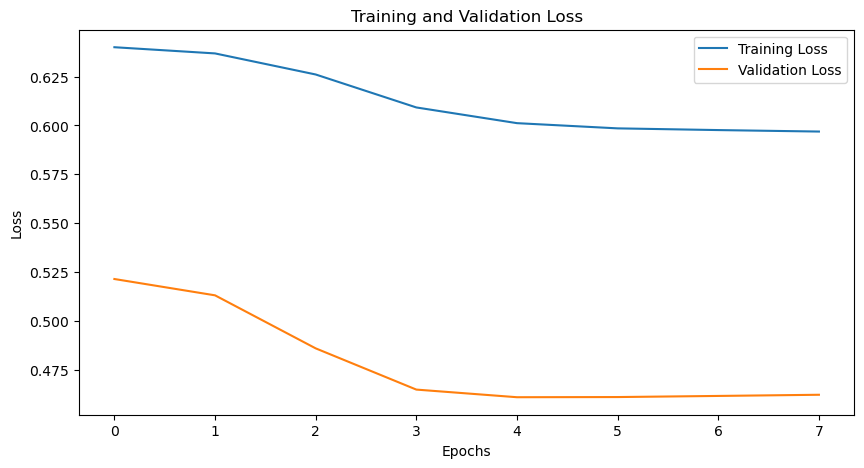

CPU times: user 44.4 s, sys: 396 ms, total: 44.8 s
Wall time: 43.4 s


In [50]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
# input_dim = 128*5+1
input_dim = stock_number
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=1,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()
# criterion = nn.MSELoss()

train_losses = []
val_losses = []

num_epochs = 10
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
total_batches = num_epochs * len(train_dataloader)
total_start_time = time.time()

for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    batch_start_time = time.time()
    
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 20 == 0:
            # print(f"Batch {i}, Loss: {loss}, train_loss: {running_loss}")
            elapsed_time = time.time() - batch_start_time
            remaining_batches = len(train_dataloader) - (i + 1)
            estimated_remaining_time_epoch = remaining_batches * (elapsed_time / (i + 1))
            
            total_elapsed_time = time.time() - total_start_time
            total_remaining_batches = total_batches - ((epoch * len(train_dataloader)) + (i + 1))
            estimated_remaining_time_total = total_remaining_batches * (total_elapsed_time / ((epoch * len(train_dataloader)) + (i + 1)))

            print(f"Batch {i}/{len(train_dataloader)}, Loss: {loss:.4f}, "
                  f"Estimated time left for epoch: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_epoch))}, "
                  f"Estimated time left for training: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_total))}")
            
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Plot Prediction vs True Values (scaler.inverse_transform)

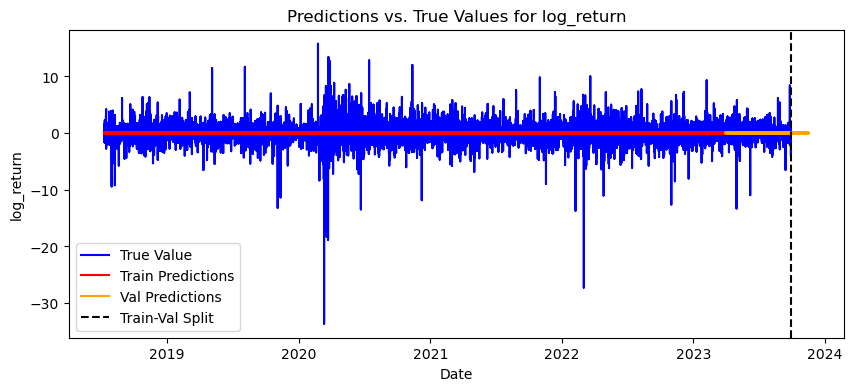

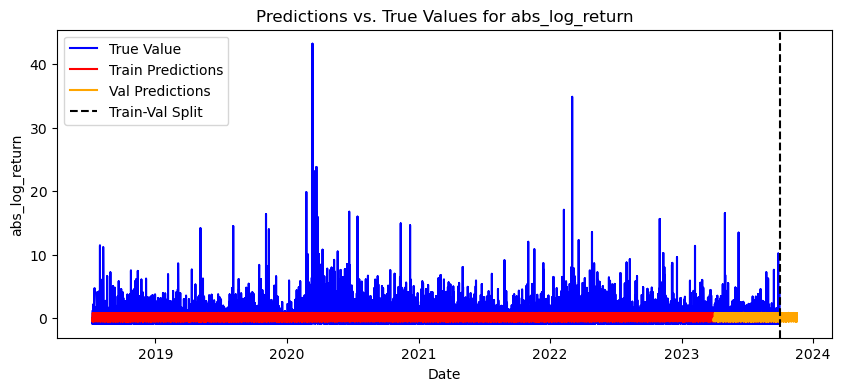

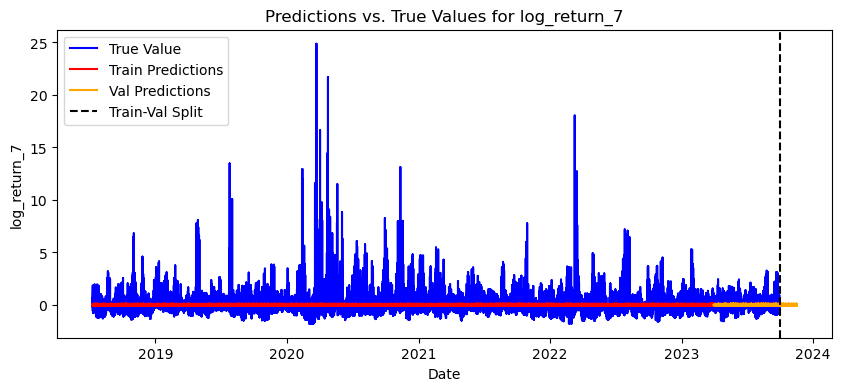

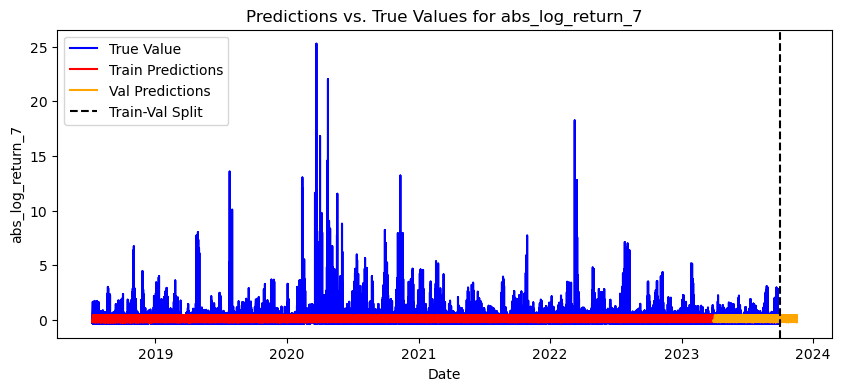

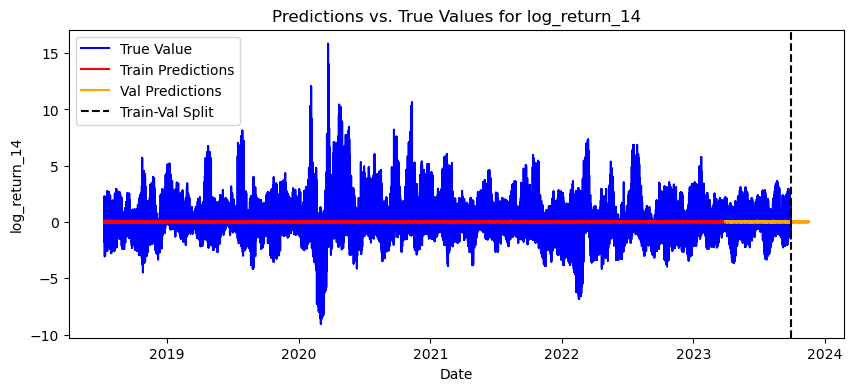

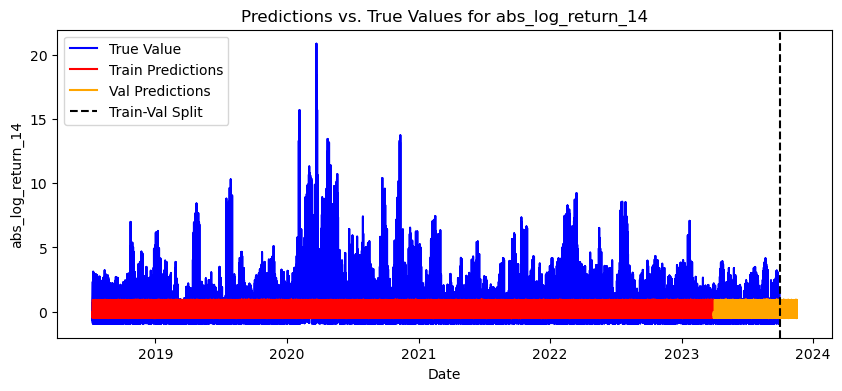

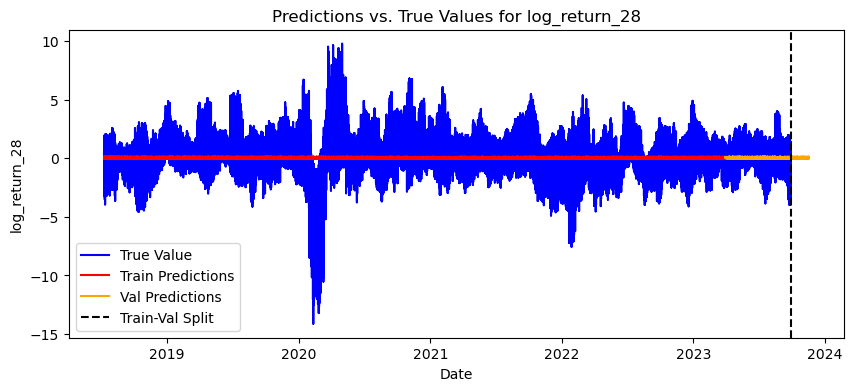

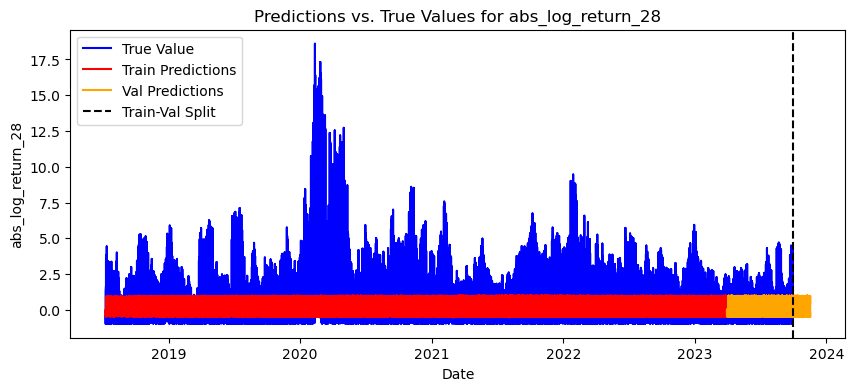

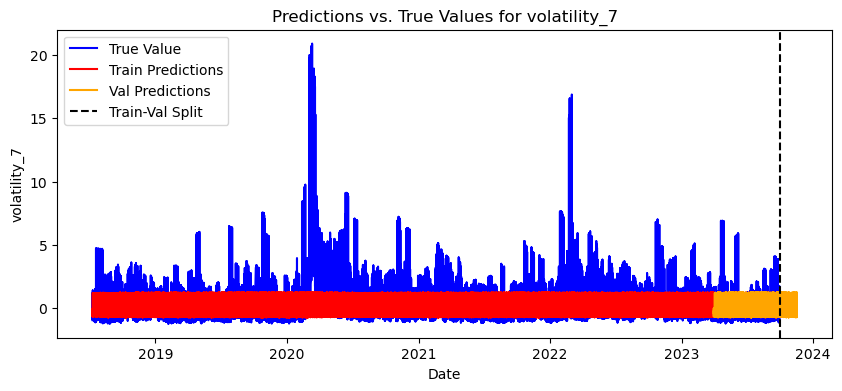

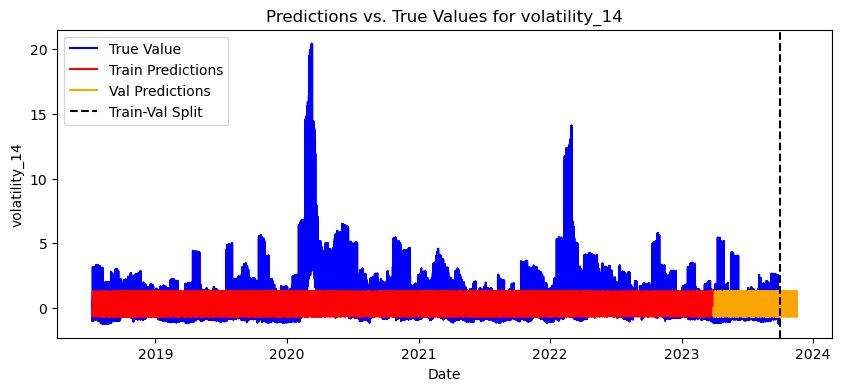

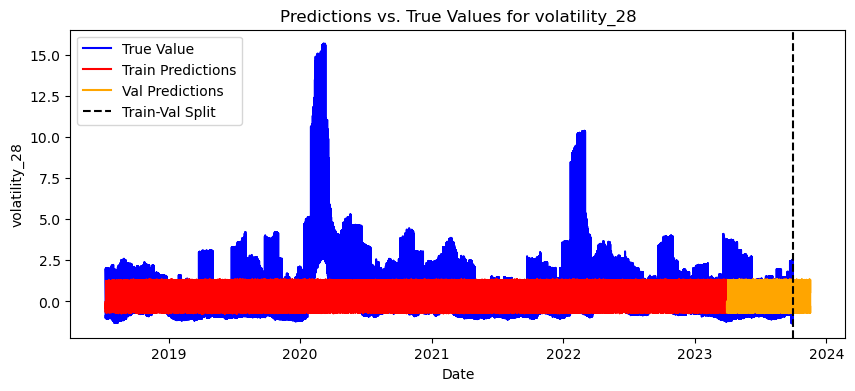

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

# Assuming the model and dataloaders are already defined and trained
# Also assuming the standardized_data is available

# Separate scaler for target columns
target_scaler = StandardScaler()
standardized_data[train_dataset.target_columns] = target_scaler.fit_transform(standardized_data[train_dataset.target_columns])

# Function to get predictions
def get_predictions(dataloader, model, device):
    model.eval()
    predictions = []
    true_values = []
    with torch.no_grad():
        for batch in dataloader:
            features = batch["features"].to(device)
            target = batch["target"].to(device)
            output, _ = model(features)
            # print(output.shape)
            predictions.append(output.cpu().numpy())
            true_values.append(target.cpu().numpy())
    return np.concatenate(predictions), np.concatenate(true_values)

# Get predictions for training and validation datasets
train_predictions, train_true_values = get_predictions(train_dataloader, model, device)
val_predictions, val_true_values = get_predictions(val_dataloader, model, device)

# Reshape predictions and true values to 2D arrays
train_predictions = train_predictions.reshape(-1, len(train_dataset.target_columns))
train_true_values = train_true_values.reshape(-1, len(train_dataset.target_columns))
val_predictions = val_predictions.reshape(-1, len(val_dataset.target_columns))
val_true_values = val_true_values.reshape(-1, len(val_dataset.target_columns))

# Inverse transform the predictions and true values using target_scaler
train_predictions = target_scaler.inverse_transform(train_predictions)
train_true_values = target_scaler.inverse_transform(train_true_values)
val_predictions = target_scaler.inverse_transform(val_predictions)
val_true_values = target_scaler.inverse_transform(val_true_values)

# Convert predictions and true values to DataFrame
train_predictions_df = pd.DataFrame(train_predictions, columns=train_dataset.target_columns)
train_true_values_df = pd.DataFrame(train_true_values, columns=train_dataset.target_columns)
val_predictions_df = pd.DataFrame(val_predictions, columns=val_dataset.target_columns)
val_true_values_df = pd.DataFrame(val_true_values, columns=val_dataset.target_columns)

# Ensure the date columns have matching lengths
train_dates = train_data.iloc[window_size:len(train_predictions) + window_size]['date'].values
if len(train_dates) < len(train_predictions_df):
    train_dates = np.append(train_dates, [train_dates[-1]] * (len(train_predictions_df) - len(train_dates)))
train_predictions_df['date'] = train_dates
train_true_values_df['date'] = train_dates

val_dates = validation_data.iloc[window_size:len(val_predictions) + window_size]['date'].values
if len(val_dates) < len(val_predictions_df):
    val_dates = np.append(val_dates, [val_dates[-1]] * (len(val_predictions_df) - len(val_dates)))
val_predictions_df['date'] = val_dates
val_true_values_df['date'] = val_dates

# Plotting function for each label
def plot_predictions_vs_true(label):
    plt.figure(figsize=(10, 4))

    # Plot the train data
    plt.plot(train_true_values_df['date'], train_true_values_df[label], label='True Value', color='blue')

    plt.plot(train_predictions_df['date'], train_predictions_df[label], label='Train Predictions', color='red')
    plt.plot(val_predictions_df['date'], val_predictions_df[label], label='Val Predictions', color='orange')

    plt.axvline(x=pd.to_datetime('2023-09-30'), color='black', linestyle='--', label='Train-Val Split')

    plt.xlabel('Date')
    plt.ylabel(label)
    plt.title(f'Predictions vs. True Values for {label}')
    plt.legend()
    plt.show()

# Plot for all labels
for label in train_dataset.target_columns:
    plot_predictions_vs_true(label)


#### Input Embedding Weights

In [52]:
input_embedding_weights = model.input_embedding.weight.detach().cpu().numpy().T
print(input_embedding_weights)

[[-0.01280962 -0.06867221  0.00754736 ...  0.10175715 -0.05671398
  -0.01515974]
 [ 0.04444048 -0.06409355  0.08345175 ... -0.13164926  0.14453769
  -0.10205023]
 [ 0.13950786 -0.09370835  0.1356361  ... -0.0844145   0.12561575
   0.05359185]
 ...
 [-0.03103049  0.1293335   0.12791312 ...  0.01616822 -0.03481797
  -0.01588582]
 [-0.09910128  0.11934582  0.13395292 ... -0.0340144  -0.05844375
  -0.04119836]
 [-0.14356104  0.11944365 -0.06017244 ...  0.09458476  0.11124197
  -0.04996181]]


In [53]:
input_embedding_weights.shape

(46, 256)

In [54]:
cosine_sim_matrix_input_embedding_weights = cosine_similarity(input_embedding_weights)
cosine_sim_matrix_input_embedding_weights

array([[ 9.9999964e-01,  1.2132172e-01, -4.4761866e-02, ...,
        -2.2299825e-03, -2.3038227e-02, -5.4475144e-02],
       [ 1.2132172e-01,  1.0000002e+00, -4.4817468e-03, ...,
        -3.3905357e-02, -5.9675105e-02,  2.4717452e-02],
       [-4.4761866e-02, -4.4817468e-03,  9.9999958e-01, ...,
        -5.6540202e-02,  9.9505973e-04, -5.0602142e-02],
       ...,
       [-2.2299825e-03, -3.3905357e-02, -5.6540202e-02, ...,
         9.9999958e-01, -1.2314523e-01, -8.5265234e-02],
       [-2.3038227e-02, -5.9675105e-02,  9.9505973e-04, ...,
        -1.2314523e-01,  9.9999982e-01,  6.1040636e-02],
       [-5.4475144e-02,  2.4717452e-02, -5.0602142e-02, ...,
        -8.5265234e-02,  6.1040636e-02,  1.0000002e+00]], dtype=float32)

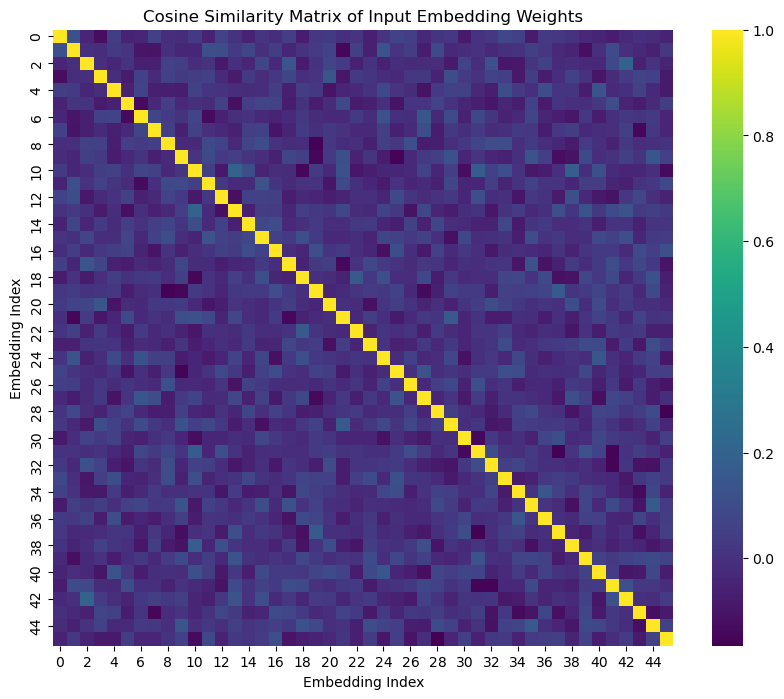

In [55]:
# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix_input_embedding_weights, annot=False, cmap='viridis')
plt.title('Cosine Similarity Matrix of Input Embedding Weights')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.show()

#### Feed_Forward Weights

In [56]:
# To get the weights of the first encoder layer
encoder_layer_weights = model.transformer.layers[0].state_dict()
encoder_layer_weights

OrderedDict([('self_attn.in_proj_weight',
              tensor([[-0.0650, -0.0646,  0.0028,  ...,  0.0155, -0.0619, -0.0353],
                      [-0.0233, -0.0026, -0.0263,  ...,  0.0039, -0.0584, -0.0701],
                      [-0.0196,  0.0500,  0.0315,  ...,  0.0251, -0.0373,  0.0651],
                      ...,
                      [ 0.0174, -0.0573, -0.0763,  ..., -0.0472, -0.0060, -0.0247],
                      [ 0.0442,  0.0292,  0.0122,  ..., -0.0525, -0.0639, -0.0175],
                      [ 0.0043, -0.0207,  0.0116,  ...,  0.0092, -0.0524, -0.0770]],
                     device='cuda:0')),
             ('self_attn.in_proj_bias',
              tensor([-1.3135e-03, -1.3873e-03, -1.2874e-03,  1.2717e-03, -1.2702e-03,
                      -1.5612e-03, -1.3106e-03,  1.2395e-03,  1.3544e-03, -1.3939e-03,
                       1.4148e-03, -1.4711e-03, -1.2248e-03,  1.4077e-03, -1.4210e-03,
                      -1.2877e-03,  5.0471e-04, -5.0432e-04,  4.9839e-04,  5.4076e-04

In [57]:
# If you want to get the weights of all encoder layers
all_encoder_layers_weights = [layer.state_dict() for layer in model.transformer.layers]
all_encoder_layers_weights

[OrderedDict([('self_attn.in_proj_weight',
               tensor([[-0.0650, -0.0646,  0.0028,  ...,  0.0155, -0.0619, -0.0353],
                       [-0.0233, -0.0026, -0.0263,  ...,  0.0039, -0.0584, -0.0701],
                       [-0.0196,  0.0500,  0.0315,  ...,  0.0251, -0.0373,  0.0651],
                       ...,
                       [ 0.0174, -0.0573, -0.0763,  ..., -0.0472, -0.0060, -0.0247],
                       [ 0.0442,  0.0292,  0.0122,  ..., -0.0525, -0.0639, -0.0175],
                       [ 0.0043, -0.0207,  0.0116,  ...,  0.0092, -0.0524, -0.0770]],
                      device='cuda:0')),
              ('self_attn.in_proj_bias',
               tensor([-1.3135e-03, -1.3873e-03, -1.2874e-03,  1.2717e-03, -1.2702e-03,
                       -1.5612e-03, -1.3106e-03,  1.2395e-03,  1.3544e-03, -1.3939e-03,
                        1.4148e-03, -1.4711e-03, -1.2248e-03,  1.4077e-03, -1.4210e-03,
                       -1.2877e-03,  5.0471e-04, -5.0432e-04,  4.9839e-0

In [58]:
# Attention weights
attention_weights = encoder_layer_weights['self_attn.in_proj_weight']

# Feedforward weights
feedforward_weights = encoder_layer_weights['linear1.weight']

print("Attention Weights:", attention_weights.shape)
print("Feedforward Weights:", feedforward_weights.shape)


Attention Weights: torch.Size([768, 256])
Feedforward Weights: torch.Size([1024, 256])


In [59]:
feedforward_weights_matrix = feedforward_weights.cpu().numpy()
feedforward_weights_matrix

array([[-0.03643596, -0.0296206 , -0.0308858 , ..., -0.05588331,
        -0.05839623,  0.03081404],
       [-0.04366363,  0.04270481, -0.04910666, ..., -0.05705114,
        -0.00166082,  0.04410173],
       [ 0.02279164,  0.05883658, -0.01733998, ...,  0.02074651,
        -0.00974327, -0.0360743 ],
       ...,
       [ 0.02885722,  0.02540256,  0.00938839, ...,  0.04476003,
        -0.01728139,  0.01021941],
       [-0.0073983 , -0.06029711,  0.06178953, ...,  0.05358525,
        -0.02297947,  0.0346071 ],
       [ 0.05351184,  0.05225507,  0.02689252, ...,  0.04146405,
        -0.03821757, -0.03897291]], dtype=float32)

In [60]:
cosine_sim_matrix_feedforward_weights = cosine_similarity(feedforward_weights_matrix)
cosine_sim_matrix_feedforward_weights

array([[ 0.99999994,  0.05929024, -0.0149957 , ..., -0.00774422,
        -0.03873602, -0.0633691 ],
       [ 0.05929024,  0.99999994,  0.11020835, ..., -0.02315806,
        -0.05863023,  0.04521647],
       [-0.0149957 ,  0.11020835,  1.        , ...,  0.03025857,
         0.0352181 ,  0.10376093],
       ...,
       [-0.00774422, -0.02315806,  0.03025857, ...,  1.0000004 ,
        -0.03461989,  0.12200354],
       [-0.03873602, -0.05863023,  0.0352181 , ..., -0.03461989,
         1.        , -0.00308954],
       [-0.0633691 ,  0.04521647,  0.10376093, ...,  0.12200354,
        -0.00308954,  1.        ]], dtype=float32)

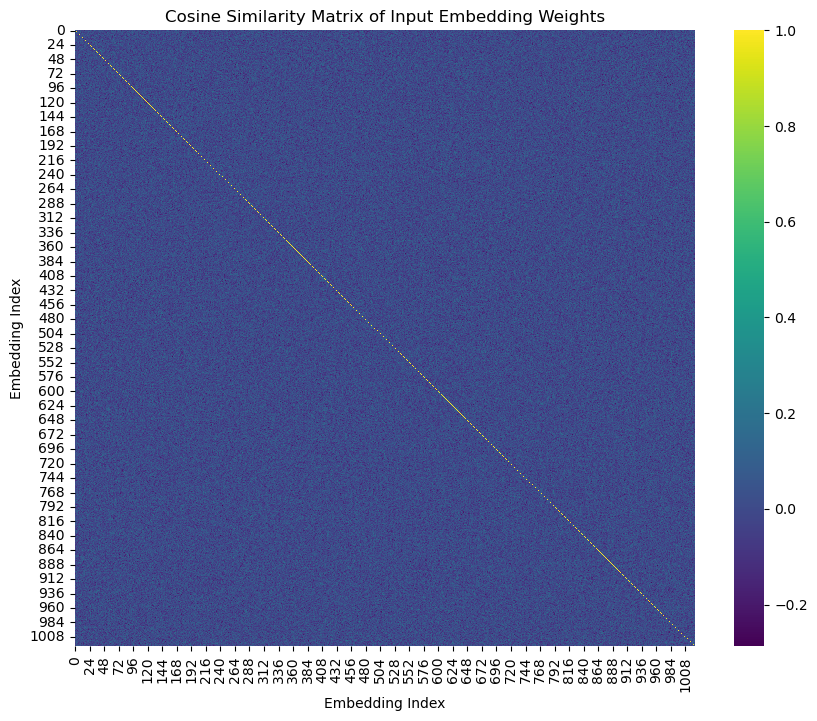

In [61]:
# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix_feedforward_weights, annot=False, cmap='viridis')
plt.title('Cosine Similarity Matrix of Input Embedding Weights')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.show()

#### Extract Last Output Embedding

In [62]:

with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))

In [63]:
output_embedding_matrix = embeddings[:,-1,:].cpu().numpy()
output_embedding_matrix

array([[ 1.2757746 ,  0.5973885 ,  0.8734906 , ...,  0.96619505,
         0.90086025,  0.57589656],
       [ 1.8166013 ,  1.3403043 ,  0.61865216, ...,  0.76047677,
         1.106143  ,  0.14064385],
       [ 0.14280997,  0.14087825,  0.6322608 , ...,  1.6424683 ,
        -0.28742352, -1.777945  ],
       ...,
       [ 1.1308428 ,  0.9155793 ,  0.98764634, ...,  0.17129408,
         0.5655776 ,  2.238621  ],
       [ 1.2360132 ,  0.7826413 ,  0.92335063, ...,  0.5554481 ,
         0.38081664,  1.6898625 ],
       [ 0.5263827 , -0.08644774,  0.7177095 , ...,  0.3024858 ,
         1.267974  , -0.0211758 ]], dtype=float32)

In [64]:
cosine_sim_matrix_out_embedding = cosine_similarity(output_embedding_matrix)
cosine_sim_matrix_out_embedding

array([[1.        , 0.8531007 , 0.35410202, ..., 0.8150883 , 0.8578209 ,
        0.29130158],
       [0.8531007 , 1.0000002 , 0.4101269 , ..., 0.8212666 , 0.8771793 ,
        0.3399774 ],
       [0.35410202, 0.4101269 , 0.9999999 , ..., 0.3850401 , 0.38499615,
        0.11060165],
       ...,
       [0.8150883 , 0.8212666 , 0.3850401 , ..., 1.0000001 , 0.93477917,
        0.3803568 ],
       [0.8578209 , 0.8771793 , 0.38499615, ..., 0.93477917, 1.        ,
        0.37642238],
       [0.29130158, 0.3399774 , 0.11060165, ..., 0.3803568 , 0.37642238,
        0.9999999 ]], dtype=float32)

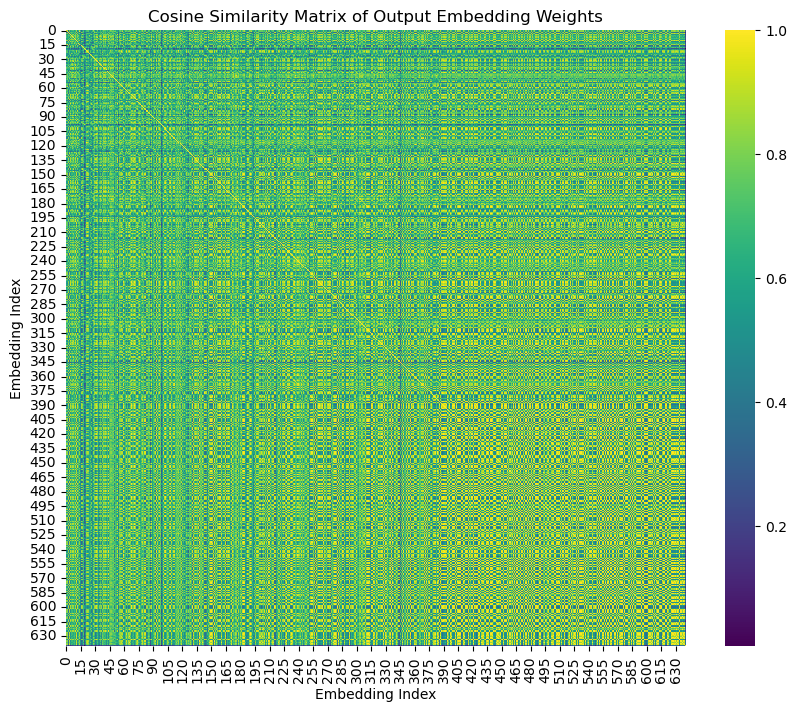

In [65]:
# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix_out_embedding, annot=False, cmap='viridis')
plt.title('Cosine Similarity Matrix of Output Embedding Weights')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.show()

#### Average Output Embedding

In [66]:
# Initialize an empty tensor to accumulate the embeddings
accumulated_embeddings = torch.zeros(641, 256).to(device)
total_batches = 0

with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        #print(embeddings)
        accumulated_embeddings += embeddings.sum(dim=1)
        # total_batches += batch["features"].size(0)
        total_batches += embeddings.size(1)

# Divide the accumulated embeddings by the total number of batches to get the average
average_embeddings = accumulated_embeddings / total_batches
print(total_batches)
average_embeddings

1318


tensor([[ 1.1157,  0.4476,  0.5855,  ...,  0.8823,  0.3150, -0.0672],
        [ 1.1152,  0.4470,  0.5858,  ...,  0.8826,  0.3140, -0.0671],
        [ 1.1149,  0.4462,  0.5851,  ...,  0.8823,  0.3127, -0.0668],
        ...,
        [ 1.0563,  0.3442,  0.6072,  ...,  0.8655,  0.2518,  0.0399],
        [ 1.0561,  0.3428,  0.6069,  ...,  0.8661,  0.2510,  0.0390],
        [ 0.5255, -0.0870,  0.7178,  ...,  0.3009,  1.2688, -0.0173]],
       device='cuda:0')

In [67]:
average_embeddings.shape

torch.Size([641, 256])

In [68]:
batch["features"].shape

torch.Size([6, 641, 46])

In [69]:
batch["features"].size(0)

6

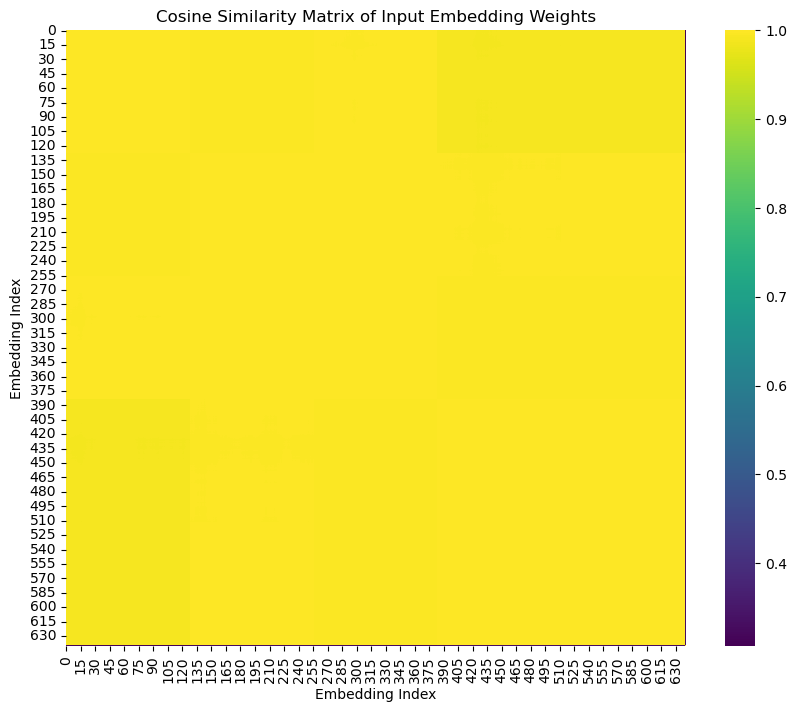

In [70]:
# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_similarity(average_embeddings.cpu().numpy()), annot=False, cmap='viridis')
plt.title('Cosine Similarity Matrix of Input Embedding Weights')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.show()